In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from tensorflow.keras.callbacks import  EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
num_classes = 10
input_shape = (28, 28, 1)
label=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
(X,y), (_, _) = keras.datasets.fashion_mnist.load_data()

<AxesSubplot:ylabel='count'>

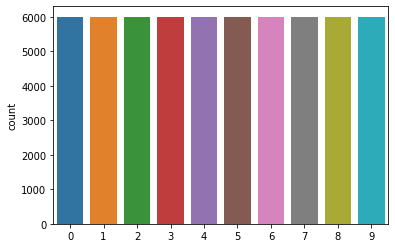

In [3]:
#check keseimbangan kelas
sns.countplot(x=y)

In [4]:
# bagi dan normalisasi data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


In [5]:
#Ekspand dimensi

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


x_train shape: (48000, 28, 28)
48000 train samples
12000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')

x_train shape: (48000, 10)
48000 train samples
12000 test samples


In [7]:
model = keras.Sequential([keras.Input(shape=input_shape),
                          layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
                          layers.MaxPooling2D(pool_size=(2, 2)),
                          layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
                          layers.MaxPooling2D(pool_size=(2, 2)),
                          layers.Flatten(),
                          layers.Dropout(0.5),
                          layers.Dense(num_classes, activation='softmax'),])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dropout (Dropout)           (None, 3200)              0

In [8]:
import datetime
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer=tf.summary.create_file_writer(log_dir)

with file_writer.as_default():
    imgs = np.reshape(X_train[:], (-1, 28, 28, 1))
    tf.summary.image('Training Data ', imgs, max_outputs = 10, step = 0)
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    

In [9]:
batch_size = 128
epochs = 15
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 5,mode='auto',verbose=1,restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test,y_test),epochs=epochs,callbacks=[earlystop,tensorboard_callback])


Epoch 1/15
375/375 [==============================] - 8s 10ms/step - loss: 0.6327 - accuracy: 0.7667 - val_loss: 0.4062 - val_accuracy: 0.8601
Epoch 2/15
375/375 [==============================] - 3s 9ms/step - loss: 0.4147 - accuracy: 0.8521 - val_loss: 0.3488 - val_accuracy: 0.8750
Epoch 3/15
375/375 [==============================] - 3s 9ms/step - loss: 0.3647 - accuracy: 0.8691 - val_loss: 0.3414 - val_accuracy: 0.8774
Epoch 4/15
375/375 [==============================] - 3s 9ms/step - loss: 0.3412 - accuracy: 0.8782 - val_loss: 0.3006 - val_accuracy: 0.8927
Epoch 5/15
375/375 [==============================] - 4s 10ms/step - loss: 0.3148 - accuracy: 0.8863 - val_loss: 0.2854 - val_accuracy: 0.8972
Epoch 6/15
375/375 [==============================] - 3s 9ms/step - loss: 0.2979 - accuracy: 0.8931 - val_loss: 0.2754 - val_accuracy: 0.9022
Epoch 7/15
375/375 [==============================] - 4s 9ms/step - loss: 0.2906 - accuracy: 0.8947 - val_loss: 0.2710 - val_accuracy: 0.9013
Epoc

In [10]:
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24520722031593323
Test accuracy: 0.9105833172798157


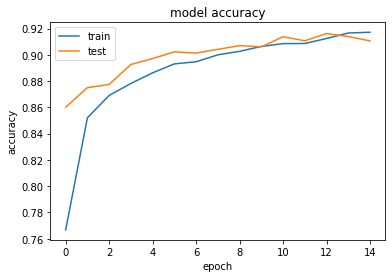

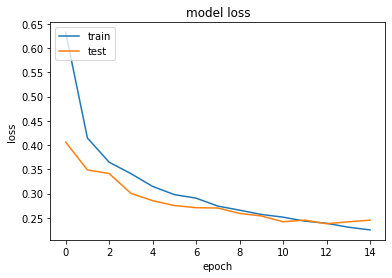

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [12]:
#save model dulu
tf.saved_model.save(model, '.')

#convert tflite
converter = tf.lite.TFLiteConverter.from_saved_model('.')
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('Model.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: .\assets


428656